In [47]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"

# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform" 
# This makes JAX allocate exactly what is needed on demand, and deallocate memory that is no longer needed (note that this is the only configuration that will deallocate GPU memory, instead of reusing it). This is very slow, so is not recommended for general use, but may be useful for running with the minimal possible GPU memory footprint or debugging OOM failures.

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["CUDA_VISIBLE_DEVICES"] = "None"

from proba_sandbox.module_sandbox.dataset.tabular import TabularLoader
from proba_sandbox.module_sandbox.dataset.base import DataConfig

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree
import pandas as pd
import wandb
import time
from src.jax_test_model import MLPModel
from src.jax_test_model import MLPModel, init_t_lambda_to_phi, init_model_tube, init_model_phi
from numpyro.infer.util import initialize_model
from jax_tqdm import scan_tqdm
from torch.utils import data


%load_ext autoreload
%autoreload 2

# %env XLA_FLAGS="--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
#                            '--xla_dump_to=xla_dump/')
%env XLA_FLAGS

#jax.devices("gpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'--xla_force_host_platform_device_count=10'

In [48]:
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7),
 CpuDevice(id=8),
 CpuDevice(id=9)]

### analyse wandb runs

In [49]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)


Figure size= [3.2489276324892766, 2.0079477038671003]


In [50]:
api = wandb.Api()
results = []
# for s_id in ['vl6382k1', 'x26ip745', 'd8bi25u9']:
# for s_id in ['67f15uxy',]:
for s_id in ['pjwottu7','4pwt4woc']:
    t_bar = tqdm(api.sweep(f"ddold/subspace_mnist/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if ((run.state == 'finished')):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config']['prior_scale'],
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['activation'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       PriorCorrection="all" if run.config['sampling']['space_config'].get(
                           'prior_correct', False) else "only t",
                       Model="LeNetti" if run.config['curve_params']['small_cnn'] else "LeNet",
                       UniformT=run.config['curve_params'].get('uniform_t_optimize', False),
                       lppd_test=run.summary.get('lppd_test', np.nan),
                       acc_test=run.summary.get('acc_test', np.nan),
                       lppd_valid=run.summary.get('lppd_valid', np.nan),
                       acc_valid=run.summary.get('acc_valid', np.nan),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(f"Encoundert problem with run {run.name}; state: {run.state}")

df = pd.DataFrame(results)
df

Sweep id: pjwottu7:   0%|          | 0/100 [00:00<?, ?it/s, dandy-sweep-99]   

Sweep id: 4pwt4woc: 100%|██████████| 100/100 [00:00<00:00, 563.32it/s, worldly-sweep-1]   


,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,...,lppd_test,acc_test,lppd_valid,acc_valid,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,r05q3hzh,mclmc,lambda,0.5,0.1,25,50,relu,10,0,...,-0.030280,0.9811,-0.035734,0.979333,1354.612900,1.0,1.0,4724,5372.9,10
1,vnqw74ix,mclmc,lambda,0.5,0.1,25,100,relu,5,2,...,-0.031307,0.9804,-0.040497,0.978917,1287.296075,1.0,1.0,2939,5010.6,10
2,ju4j7r0i,mclmc,lambda,0.5,0.1,25,50,relu,2,4,...,-0.034103,0.9793,-0.038817,0.979250,1264.057083,1.0,1.0,4450,4971.5,10
3,qof8jmlm,mclmc,lambda,0.5,0.1,25,500,relu,2,4,...,-0.030433,0.9790,-0.035202,0.979167,1263.693331,1.0,1.0,3382,4393.0,10
4,91x7tfu1,mclmc,lambda,0.5,0.1,25,50,relu,5,1,...,-0.034929,0.9817,-0.032238,0.981750,1287.616350,1.0,1.0,5411,5858.8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,i6fmtkeg,mclmc,lambda,0.5,0.1,25,1,relu,2,0,...,-0.028101,0.9831,-0.040988,0.981583,2893.985860,1.0,1.0,2538,4136.0,10
196,5kpb1mt2,mclmc,lambda,0.5,0.1,25,10,relu,2,0,...,-0.029842,0.9808,-0.040989,0.975167,2892.432958,1.0,1.0,4642,5552.0,10
197,dxvqd6u0,mclmc,lambda,0.5,0.1,25,50,relu,2,0,...,-0.030150,0.9807,-0.039771,0.978417,2893.735543,1.0,1.0,3948,4383.0,10
198,rgga6aie,mclmc,lambda,0.5,0.1,25,100,relu,2,0,...,-0.029276,0.9808,-0.039548,0.980333,2897.795320,1.0,1.0,4714,4977.5,10


In [51]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan]

,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,...,lppd_test,acc_test,lppd_valid,acc_valid,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward


In [52]:
df_clean = df[~idx_config_with_nan]
idx_ids = [col for col in df.columns if col[0].isupper()]
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
variable_idx = []
for c in df_clean.columns:
    if c not in [*value_ids, 'Id']:
        unique_ = df_clean[c].unique()
        print(c, unique_)
        if (len(unique_) > 1) and (c != 'Seed'):
            variable_idx.append(c)
print(f"\nExperiment differs in {variable_idx} configs")

Unique configuartions: 
Sampler ['mclmc']
Space ['lambda']
PriorScale [0.5]
TubeScale [0.1]
Epsilon [25]
Temperature [ 50 100 500   1  10]
Activation ['relu']
SubspaceDim [10  5  2 20]
Seed [0 2 4 1 3]
PriorCorrection ['only t']
Model ['LeNet']
UniformT [False  True]

Experiment differs in ['Temperature', 'SubspaceDim', 'UniformT'] configs


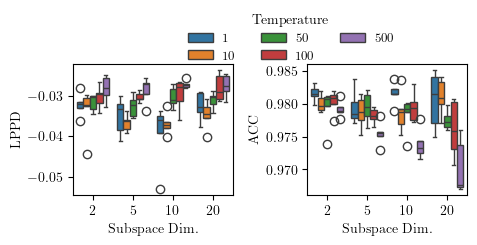

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
df_subset = df_clean[df_clean['UniformT'] == True]
g = sns.boxplot(data=df_subset, x='SubspaceDim', y='lppd_test', hue='Temperature', palette='tab10', ax=ax[0], legend=False)
g = sns.boxplot(data=df_subset, x='SubspaceDim', y='acc_test', hue='Temperature', palette='tab10', ax=ax[1])
# Put the legend outside the plot
ax[0].set_ylabel("LPPD")
ax[1].set_ylabel("ACC")
ax[0].set_xlabel("Subspace Dim.")
ax[1].set_xlabel("Subspace Dim.")
plt.tight_layout()
sns.move_legend(g, "center", bbox_to_anchor=(-0.1, 1.2),
                ncol=3, title='Temperature', frameon=False)
plt.savefig("figures/subspace_mnist_all_temp.pdf", bbox_inches='tight')

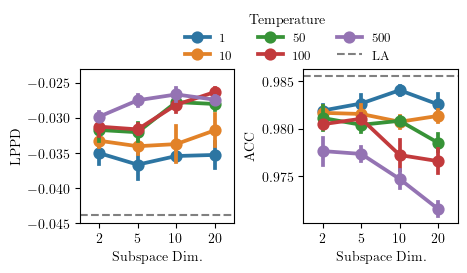

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
df_subset = df_clean[df_clean['UniformT'] == False]
g = sns.pointplot(data=df_subset, x='SubspaceDim', y='lppd_test',
                  hue='Temperature', errorbar='se', ax=ax[0], legend=False, palette=['#2d75a2', '#e28228', '#379337', '#c23a3c', '#9473b3'])
g = sns.pointplot(data=df_subset, x='SubspaceDim', y='acc_test',
                  hue='Temperature', errorbar='se', ax=ax[1], palette=['#2d75a2', '#e28228', '#379337', '#c23a3c', '#9473b3'])
ax[0].set_ylabel("LPPD")
ax[1].set_ylabel("ACC")
xlim1 = ax[0].get_xlim()
xlim2 = ax[1].get_xlim()
ax[0].hlines(-0.0438, *xlim1, linestyles='dashed', color='gray')
ax[1].hlines(0.98558, *xlim2, linestyles='dashed', label="LA", color='gray')
# sns.move_legend(ax[1], "center", bbox_to_anchor=(-0.25, 1.15), ncol=2, title='Path optimization with:', frameon=False)
handles, labels = ax[1].get_legend_handles_labels()


def label_fn(x):
    if x == 'False':
        return r'$t\sim U(0,1)$'
    elif x == 'True':
        return r'$s\sim U(0,\mathcal{S})$'
    else:
        return x


new_labels = [label_fn(label) for label in labels]
ax[1].legend(handles, new_labels, loc='center',
             bbox_to_anchor=(-0.25, 1.15), ncol=3, frameon=False)

ax[0].set_xlabel("Subspace Dim.")
ax[1].set_xlabel("Subspace Dim.")
ax[0].set_ylim(-0.045, -0.023)
ax[0].set_xlim(xlim1)
ax[1].set_xlim(xlim2)

sns.move_legend(g, "center", bbox_to_anchor=(-0.1, 1.2),
                ncol=3, title='Temperature', frameon=False)
fig.subplots_adjust(wspace=0.45)
plt.savefig("figures/subspace_mnist_all_temp.pdf", bbox_inches='tight')

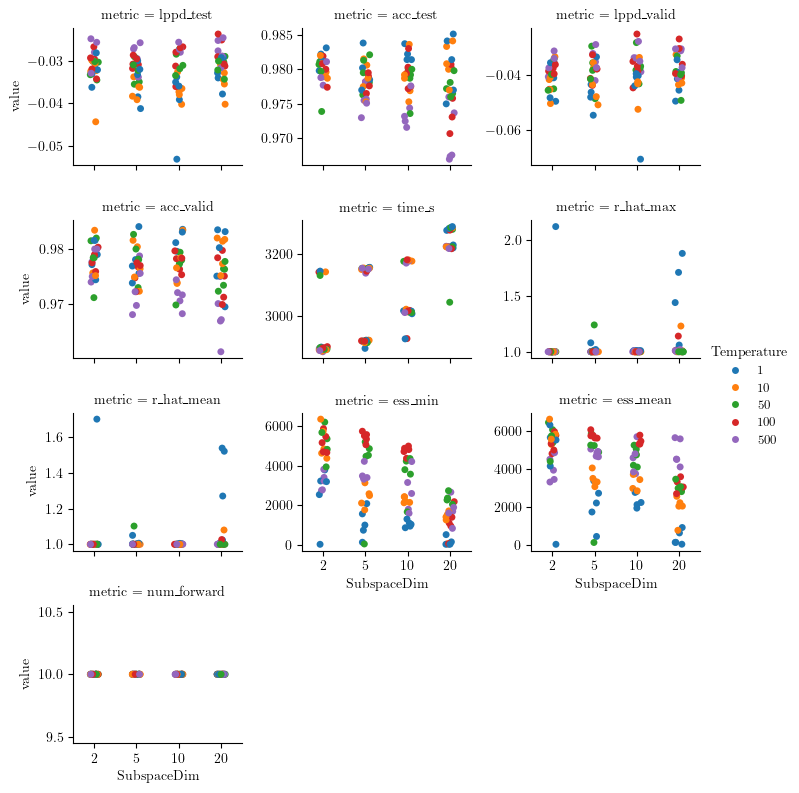

In [9]:
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False)

g = sns.catplot(data=df_melt.reset_index(), x='SubspaceDim', y='value', col='metric',
                kind='strip', hue='Temperature', palette='tab10', sharey=False, col_wrap=3, height=figsize[1], aspect=1.2)
                

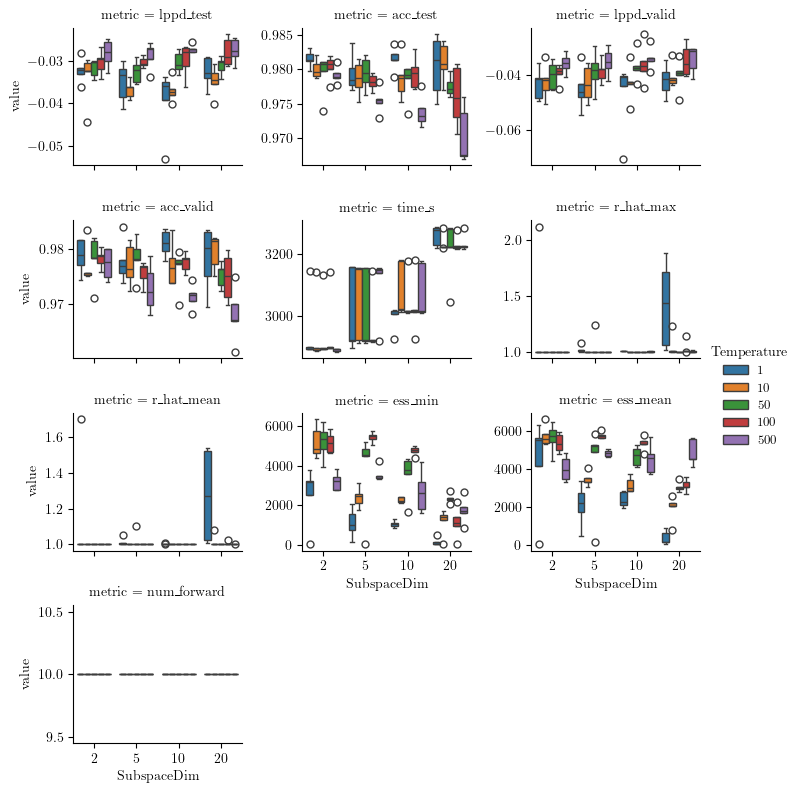

In [10]:
g = sns.catplot(data=df_melt.reset_index(), x='SubspaceDim', y='value', col='metric',
                kind='box', hue='Temperature', palette='tab10', sharey=False, col_wrap=3, height=figsize[1], aspect=1.2)

#### test performance with selected Temperature according best valid lppd

In [54]:
idx_max_lppd_valid = df_clean.groupby(
    ['SubspaceDim', 'Seed', 'UniformT'])['lppd_valid'].idxmax()
df_best_t = df_clean.loc[idx_max_lppd_valid]
df_best_t.set_index(idx_ids).groupby(
    ['SubspaceDim', 'UniformT']).mean()

lppd_test  acc_test  lppd_valid  acc_valid       time_s  \
SubspaceDim UniformT                                                            
2           False     -0.029856   0.97764   -0.036779   0.976200  2668.176626   
            True      -0.028230   0.97920   -0.035671   0.977333  2892.160104   
5           False     -0.028131   0.97756   -0.033614   0.976583  2963.772422   
            True      -0.028592   0.97550   -0.035035   0.972883  3101.814941   
10          False     -0.026996   0.97822   -0.032287   0.976150  3100.701451   
            True      -0.027059   0.97524   -0.033188   0.973000  3045.459767   
20          False     -0.026304   0.97482   -0.032181   0.972233  3246.992671   
            True      -0.026343   0.97464   -0.033116   0.973333  3231.302364   

                      r_hat_max  r_hat_mean  ess_min  ess_mean  num_forward  
SubspaceDim UniformT                                                         
2           False         1.000      1.0000   3223.4   3840.00         10.0  
            True          1.000      1.0000   3200.6   3996.10         10.0  
5           False         1.000      1.0000   3790.2   5020.24         10.0  
            True          1.000      1.0000   3567.4   4810.80         10.0  
10          False         1.000      1.0000   3092.4   5207.42         10.0  
            True          1.002      1.0002   3331.4   4905.36         10.0  
20          False         1.020      1.0032   1044.2   3684.40         10.0  
            True          1.008      1.0006   1539.0   4113.72         10.0

In [13]:
# selected temperature
df_best_t.set_index(['SubspaceDim', 'Seed', 'UniformT'])[
    ['Temperature', 'lppd_test']]

Temperature  lppd_test
SubspaceDim Seed UniformT                        
2           0    False             500  -0.027955
                 True              500  -0.024773
            1    False             500  -0.030271
                 True              500  -0.032895
            2    False             500  -0.031834
                 True              500  -0.029927
            3    False             500  -0.028790
                 True              500  -0.025601
            4    False             500  -0.030433
                 True              500  -0.027953
5           0    False             500  -0.025716
                 True              500  -0.026848
            1    False             500  -0.027656
                 True              500  -0.025704
            2    False             500  -0.027228
                 True              500  -0.027168
            3    False             500  -0.030340
                 True              500  -0.033800
            4    False             100  -0.029715
                 True              500  -0.029442
10          0    False             500  -0.028065
                 True              500  -0.025579
            1    False             100  -0.025115
                 True              100  -0.026672
            2    False              50  -0.029287
                 True              500  -0.027281
            3    False             500  -0.027101
                 True              500  -0.027808
            4    False              50  -0.025415
                 True              500  -0.027957
20          0    False             500  -0.025599
                 True              500  -0.025173
            1    False             100  -0.025192
                 True              100  -0.025058
            2    False             500  -0.026689
                 True              500  -0.028835
            3    False             500  -0.028520
                 True              100  -0.028996
            4    False              50  -0.025520
                 True              100  -0.023652

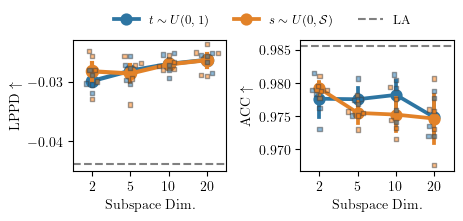

In [56]:
df_subset = df_best_t
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.swarmplot(data=df_subset, y='lppd_test', x='SubspaceDim',
              hue="UniformT", marker="s", ax=ax[0], legend=False, size=3, alpha=0.5, linewidth=1., native_scale=False)
sns.pointplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue="UniformT",
              ax=ax[0], legend=False, linewidth=3., errorbar='se', native_scale=False, palette=['#2d75a2', '#e28228'])
# ax[0].set_xscale('log')
sns.swarmplot(data=df_subset, y='acc_test', x='SubspaceDim',
              hue="UniformT", marker="s", ax=ax[1], legend=False, size=3, alpha=0.5, linewidth=1., native_scale=False)
sns.pointplot(data=df_subset, y='acc_test',
              x='SubspaceDim', hue="UniformT", ax=ax[1], native_scale=False, palette=['#2d75a2', '#e28228'])
# ax[1].set_xscale('log')
plt.tight_layout()
ax[0].set_ylabel(r"LPPD $\uparrow$")
ax[1].set_ylabel(r"ACC $\uparrow$")
xlim1 = ax[0].get_xlim()
xlim2 = ax[1].get_xlim()
ax[0].hlines(-0.0438, *xlim1, linestyles='dashed', color='gray')
ax[1].hlines(0.98558, *xlim2, linestyles='dashed', label="LA", color='gray')
# sns.move_legend(ax[1], "center", bbox_to_anchor=(-0.25, 1.15), ncol=2, title='Path optimization with:', frameon=False)
handles, labels = ax[1].get_legend_handles_labels()
def label_fn(x):
    if x == 'False':
        return r'$t\sim U(0,1)$'
    elif x == 'True':
        return r'$s\sim U(0,\mathcal{S})$'
    else:
        return x
new_labels = [label_fn(label) for label in labels]
ax[1].legend(handles, new_labels, loc='center', bbox_to_anchor=(-0.25, 1.15), ncol=3, frameon=False)

ax[0].set_xlabel("Subspace Dim.")
ax[1].set_xlabel("Subspace Dim.")
ax[0].set_ylim(-0.045, -0.023)
ax[0].set_xlim(xlim1)
ax[1].set_xlim(xlim2)
plt.savefig("figures/subspace_mnist_best_t.pdf", bbox_inches='tight')

/home/daniel/miniconda3/envs/jax_torch/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


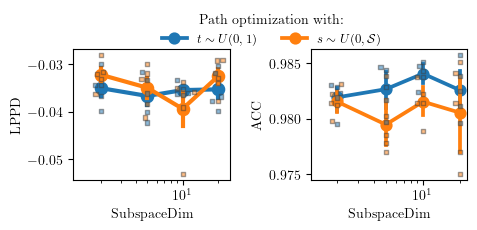

In [53]:
# with selected temperature
df_subset = df_clean[df_clean['Temperature'] == 1.]
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.swarmplot(data=df_subset, y='lppd_test', x='SubspaceDim',
              hue="UniformT", marker="s", ax=ax[0], legend=False, size=3, alpha=0.5, linewidth=1., native_scale=True)
sns.pointplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue="UniformT",
              ax=ax[0], legend=False, linewidth=3., errorbar='se', native_scale=True)
ax[0].set_xscale('log')
sns.swarmplot(data=df_subset, y='acc_test', x='SubspaceDim',
              hue="UniformT", marker="s", ax=ax[1], legend=False, size=3, alpha=0.5, linewidth=1., native_scale=True)
sns.pointplot(data=df_subset, y='acc_test',
              x='SubspaceDim', hue="UniformT", ax=ax[1], native_scale=True)
ax[1].set_xscale('log')
plt.tight_layout()
ax[0].set_ylabel("LPPD")
ax[1].set_ylabel("ACC")
# sns.move_legend(ax[1], "center", bbox_to_anchor=(-0.25, 1.15), ncol=2, title='Path optimization with:', frameon=False)
handles, labels = ax[1].get_legend_handles_labels()
new_labels = [r'$t\sim U(0,1)$' if label ==
              'False' else r'$s\sim U(0,\mathcal{S})$' for label in labels]
ax[1].legend(handles, new_labels, loc='center', bbox_to_anchor=(-0.25,
             1.15), ncol=2, title='Path optimization with:', frameon=False)

# ax[0].set_ylim(-0.035, -0.023)
plt.savefig("figures/subspace_mnist_t1.pdf", bbox_inches='tight')

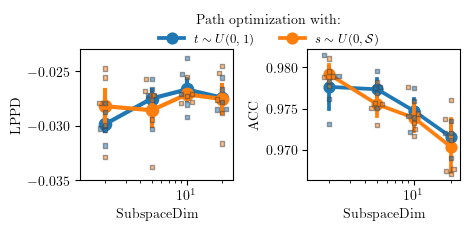

In [54]:
# with selected temperature
df_subset = df_clean[df_clean['Temperature'] == 500.]

fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.swarmplot(data=df_subset, y='lppd_test', x='SubspaceDim',
              hue="UniformT", marker="s", ax=ax[0], legend=False, size=3, alpha=0.5, linewidth=1., native_scale=True)
sns.pointplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue="UniformT",
              ax=ax[0], legend=False, linewidth=3., errorbar='se', native_scale=True)
ax[0].set_xscale('log')
sns.swarmplot(data=df_subset, y='acc_test', x='SubspaceDim',
              hue="UniformT", marker="s", ax=ax[1], legend=False, size=3, alpha=0.5, linewidth=1., native_scale=True)
sns.pointplot(data=df_subset, y='acc_test',
              x='SubspaceDim', hue="UniformT", ax=ax[1], native_scale=True)
ax[1].set_xscale('log')
plt.tight_layout()
ax[0].set_ylabel("LPPD")
ax[1].set_ylabel("ACC")
# sns.move_legend(ax[1], "center", bbox_to_anchor=(-0.25, 1.15), ncol=2, title='Path optimization with:', frameon=False)
handles, labels = ax[1].get_legend_handles_labels()
new_labels = [r'$t\sim U(0,1)$' if label ==
              'False' else r'$s\sim U(0,\mathcal{S})$' for label in labels]
ax[1].legend(handles, new_labels, loc='center', bbox_to_anchor=(-0.25,
             1.15), ncol=2, title='Path optimization with:', frameon=False)

ax[0].set_ylim(-0.035, -0.023)

plt.savefig("figures/subspace_mnist_t500.pdf", bbox_inches='tight')

### model and data definition

In [4]:
from proba_sandbox.data.dataset_generators.mnist import MNISTGenerator    
mnistgen = MNISTGenerator(
            batch_size=480,
            data_dir=f'./proba_sandbox/data/generated_data',
            seed=0,
        )
train_loader, val_loader, test_loader = mnistgen._create_np_data_loaders()
ds = train_loader.dataset
arr = [ds[i] for i in range(len(ds))]
x, y = data.default_collate(arr)
x, y = jnp.array(x.numpy().transpose(0, 2, 3, 1)), jnp.array(y.numpy())

ds = val_loader.dataset
arr = [ds[i] for i in range(len(ds))]
x_val, y_val = data.default_collate(arr)
x_val, y_val = jnp.array(x_val.numpy().transpose(
    0, 2, 3, 1)), jnp.array(y_val.numpy())

ds = test_loader.dataset
arr = [ds[i] for i in range(len(ds))]
x_test, y_test = data.default_collate(arr)
x_test, y_test = jnp.array(x_test.numpy().transpose(
    0, 2, 3, 1)), jnp.array(y_test.numpy())

In [6]:
config = {
    'curve_params': {'k': 10,
                     'model_kwargs': {'activation': 'relu'},
                     'n_samples': 1,
                     'lr': 0.005,
                     'out_scale': 0.05,
                     'optimize_distparams': False,
                     'num_epochs': 10},
    'sampling': {'space_config': {'space': 'lambda',
                                  'prior_scale': .5,
                                  'tube_scale': 1.,
                                  'prior_correct': False,
                                  'epsilon': 25.},
                 'num_chains': 10,
                 'temperature': 1.,
                 'num_warmup': 1000,
                 'num_draws': 1000,
                 'sampler': 'mclmc'},
    'rng_seed': 0
}

In [7]:
# from proba_sandbox.module_sandbox.config.models import LeNettiConfig
# from src.jax_test_model import LeNetti

# model_config = LeNettiConfig(activation=config['curve_params']['model_kwargs']['activation'],
#                              out_dim=10,
#                              use_bias=True)
# model = LeNetti(model_config)

# print(model.tabulate(jax.random.key(0), x[0:2],
#                    compute_flops=False, compute_vjp_flops=False))

In [8]:
from proba_sandbox.module_sandbox.config.models import LeNetConfig
from src.jax_test_model import LeNet

model_config = LeNetConfig(activation=config['curve_params']['model_kwargs']['activation'],
                           out_dim=10,
                           use_bias=True)
model = LeNet(model_config)

print(model.tabulate(jax.random.key(0), x[0:2],
                     compute_flops=False, compute_vjp_flops=False))


                                 LeNet Summary                                  
┏━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path  ┃ module ┃ inputs             ┃ outputs            ┃ params            ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│       │ LeNet  │ float32[2,28,28,1] │ float32[2,10]      │                   │
├───────┼────────┼────────────────────┼────────────────────┼───────────────────┤
│ conv1 │ Conv   │ float32[2,28,28,1] │ float32[2,28,28,6] │ bias: float32[6]  │
│       │        │                    │                    │ kernel:           │
│       │        │                    │                    │ float32[5,5,1,6]  │
│       │        │                    │                    │                   │
│       │        │                    │                    │ 156 (624 B)       │
├───────┼────────┼────────────────────┼────────────────────┼───────────────────┤
│ conv2 │ Conv   │ float32[

In [9]:
from src.jax_subspace_curve import UniformTSubspace, CategorySubspace

class UnifromTCategory(UniformTSubspace, CategorySubspace):
    pass

In [11]:
class CategorySubspace(SubspaceModel):
    def __init__(self, model, k, n_samples):
        super().__init__(model, k, n_samples, np.inf, False)
    
    @partial(jit, static_argnums=(0,))
    def nll(self, params, t, x, y):
        """
        Computes the negative log-likelihood loss of the model.

        Parameters:
        - params: The parameters of the model.
        - t: The time parameter.
        - x: The input data.
        - y: The target output.

        Returns:
        - The negative log-likelihood loss.

        """
        logits = self(params['params'], t, x)  # shape (n_samples, n_data, output_dim)


        nll = jax.vmap(optax.softmax_cross_entropy_with_integer_labels, in_axes=(0, None))(logits, y)
        return nll
    
    @partial(jit, static_argnums=(0, 5))
    def compute_loss(self, key, params, x, y, n_samples=1):
        """
        Computes the loss of the model.

        Parameters:
        - key: The random key for generating random numbers.
        - params: The parameters of the model.
        - x: The input data.
        - y: The target output.
        - n_samples: The number of samples to use for computing the loss.

        Returns:
        - The computed loss.

        """
        # Sample t param of Bezier curve

        t = random.uniform(key, (n_samples,), minval=0., maxval=1.)
        loss = self.nll(params, t, x, y).mean(-1)
        # jax.debug.print(f'loss shape: {loss.shape}')

        cp_w = pytree_to_matrix(params['params'], self.k)
        curve, d_bezier = bezier_curve(self.k+1, cp_w)
        tt = jnp.linspace(0., 1., 10_000)
        bezier_grad = jax.vmap(d_bezier)(tt)
        curve_length = jnp.trapezoid(
            jnp.linalg.norm(bezier_grad, axis=-1), tt)
        grads = jax.vmap(d_bezier)(t)
        weights = jnp.linalg.norm(grads, axis=-1) / curve_length

        # t_dist = BezierTspaceUnifrom(d_bezier)
        # t = t_dist.sample(key, (n_samples,))

        weighted_loss = jnp.einsum('n,n->', weights, loss)/n_samples
        return weighted_loss

### fit curve model

In [10]:
# logger = wandb.init(project="subspace_test", config=config)
k = config['curve_params']['k']
rng_key = random.PRNGKey(config['rng_seed'])
rng_key, init_key = random.split(rng_key)
s_model = UnifromTCategory(
    model, k,
    n_samples=config['curve_params']['n_samples'])
params = s_model.init_params(init_key, x[0:2])

cp_w = pytree_to_matrix(params['params'], k)
curve, d_bezier = bezier_curve(k+1, cp_w)
tt = jnp.linspace(0., 1., 10_000)
bezier_grad = jax.vmap(d_bezier)(tt)
curve_length = jnp.trapezoid(
    jnp.linalg.norm(bezier_grad, axis=-1), tt)
curve_length

Array(55.52646, dtype=float32)

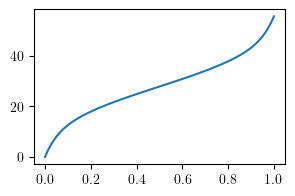

In [11]:

cum_length = cumulative_trapezoid(
    jnp.linalg.norm(bezier_grad, axis=-1), tt)
plt.plot((tt[1:]+tt[:-1])/2, cum_length)

batch_size: 480


2024-10-02 15:24:48.595555: W external/xla/xla/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-02 15:24:48.945635: W external/xla/xla/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  0%|          | 0/50 [00:00<?, ?it/s]

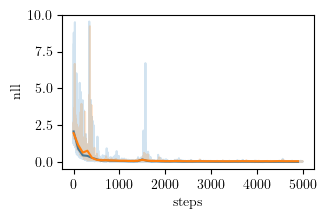

In [12]:
# imporved mini-batch approach with scan

# logger = wandb.init(project="subspace_test", config=config)
k = config['curve_params']['k']
rng_key = random.PRNGKey(config['rng_seed'])
rng_key, init_key = random.split(rng_key)
s_model = UnifromTCategory(
    model, k,
    n_samples=config['curve_params']['n_samples'])
params = s_model.init_params(init_key, x[0:2])

# Train
lr = config['curve_params']['lr']
optimizer = optax.adam(lr)
opt_state = optimizer.init(params['params'])

losses = []
valid_losses = []
best_loss = np.inf
best_params = params
epochs = config['curve_params']['num_epochs']
epochs = 50
batch_size = len(y)//100
print(f"batch_size: {batch_size}")

def train_batch(carry, batch):
    x_, y_ = batch
    rng_key, params, opt_state, best_loss, best_params = carry
    rng_key, subkey = random.split(rng_key)
    loss, params, opt_state = s_model.train_step(
        subkey, params, x_, y_, opt_state, optimizer)
    # validate
    rng_key, subkey = random.split(rng_key)
    val_loss = s_model.compute_loss(
        subkey, params, x_val, y_val, n_samples=10)
    best_params = jax.lax.cond(
        val_loss < best_loss, lambda x: params, lambda x: best_params, None)
    best_loss = jnp.minimum(best_loss, val_loss)
    return (rng_key, params, opt_state, best_loss, best_params), (loss, val_loss)

@scan_tqdm(epochs)
def train(carry, _):
    rng_key = carry[0]
    shuffel = jax.random.permutation(rng_key, jnp.arange(y.shape[0]))
    x_ = x[shuffel].reshape(-1, batch_size, 28, 28, 1)
    y_ = y[shuffel].reshape(-1, batch_size)
    carry, (loss_batch, valid_loss_batch) = jax.lax.scan(train_batch, carry, (x_, y_))
    return carry, (loss_batch, valid_loss_batch)


carry = (rng_key, params, opt_state, best_loss, best_params)

# for epoch in tqdm(range(epochs)):
#     rng_key = carry[0]
#     shuffel = jax.random.permutation(rng_key, jnp.arange(y.shape[0]))
#     x_ = x[shuffel].reshape(-1, batch_size, 28, 28, 1)
#     y_ = y[shuffel].reshape(-1, batch_size)
#     carry, (loss, valid_loss) = jax.lax.scan(train_batch, carry, (x_, y_))
#     losses.append(loss.mean())
#     valid_losses.append(valid_loss.mean())

carry, (losses, valid_losses) = jax.lax.scan(train, carry, jnp.arange(epochs))
rng_key, params, opt_state, best_loss, best_params = carry

plt.plot(np.array(losses).flatten(), alpha=0.2)
plt.plot(np.arange(0, epochs*100, 100),
         np.array(losses).mean(-1), c=plt.get_cmap('tab10')(0))
plt.plot(np.array(valid_losses).flatten(), alpha=0.2)
plt.plot(np.arange(0, epochs*100, 100),
         np.array(valid_losses).mean(-1), c=plt.get_cmap('tab10')(1))
plt.ylabel("nll")
plt.xlabel("steps")
plt.show()
# wandb.finish()

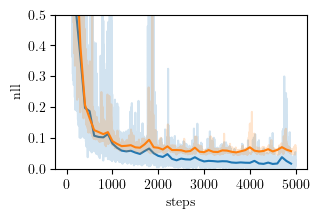

In [21]:
plt.plot(np.array(losses).flatten(), alpha=0.2)
plt.plot(np.arange(0, epochs*100, 100),
         np.array(losses).mean(-1), c=plt.get_cmap('tab10')(0))
plt.plot(np.array(valid_losses).flatten(), alpha=0.2)
plt.plot(np.arange(0, epochs*100, 100),
         np.array(valid_losses).mean(-1), c=plt.get_cmap('tab10')(1))
plt.ylim(0, 0.5)
plt.ylabel("nll")
plt.xlabel("steps")
plt.show()

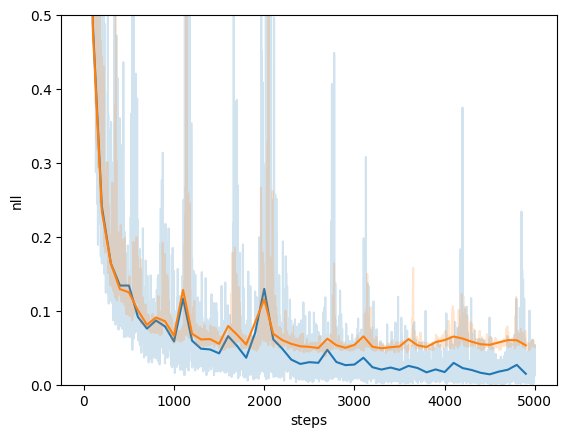

In [9]:
plt.plot(np.array(losses).flatten(), alpha=0.2)
plt.plot(np.arange(0, epochs*100, 100),
         np.array(losses).mean(-1), c=plt.get_cmap('tab10')(0))
plt.plot(np.array(valid_losses).flatten(), alpha=0.2)
plt.plot(np.arange(0, epochs*100, 100),
         np.array(valid_losses).mean(-1), c=plt.get_cmap('tab10')(1))
plt.ylim(0, 0.5)
plt.ylabel("nll")
plt.xlabel("steps")
plt.show()

In [18]:
rng_key, params, opt_state, best_loss, best_params = carry
best_loss

Array(0.04562529, dtype=float32)

In [19]:
def acc_fn(params, t, x, y):
    logits = s_model(params['params'], t, x)
    return (logits.argmax(-1) == y).mean(-1)


ac_ = acc_fn(best_params, jnp.linspace(0, 1, 20), x_val, y_val).mean()
print(f"Valid accuracy: {ac_}")

2024-09-26 17:38:40.509303: W external/xla/xla/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 17:38:40.509332: W external/xla/xla/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 17:38:40.509344: W external/xla/xla/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 17:38:40.812706: W external/xla/xla/tsl/framework/bfc_allocato

Valid accuracy: 0.9852250218391418


In [20]:
ac_ = acc_fn(best_params, jnp.linspace(0, 1, 20), x_test, y_test).mean()
print(f"Test accuracy: {ac_}")

Test accuracy: 0.9863900542259216


best loss: -0.045988403260707855


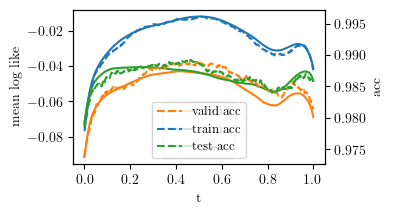

In [23]:
fig, ax = plt.subplots(1, 1)
t_space = jnp.linspace(0.0, 1.0, 500)

# valid
forward = jax.jit(lambda t: s_model.nll(
    best_params, t, x_val, y_val).mean(axis=-1))
# t_spae with shape for (sequential shape and vmapped shape)
nll = jax.lax.map(forward, t_space.reshape(-1, 20)).flatten()
acc = jax.lax.map(lambda t: acc_fn(
    best_params, t, x_val, y_val), t_space.reshape(-1, 20)).flatten()
ax.plot(t_space, -nll, label="valid", c=plt.get_cmap('tab10')(1))
ax2 = ax.twinx()
ax2.plot(t_space, acc, label="valid acc",
         c=plt.get_cmap('tab10')(1), linestyle="--")
# train
forward = jax.jit(lambda t: s_model.nll(
    best_params, t, x, y).mean(axis=-1))
nll = jax.lax.map(forward, t_space.reshape(-1, 2)).flatten()
acc = jax.lax.map(lambda t: acc_fn(
    best_params, t, x, y), t_space.reshape(-1, 2)).flatten()
ax.plot(t_space, -nll, label="train", c=plt.get_cmap('tab10')(0))
ax2.plot(t_space, acc, label="train acc",
         c=plt.get_cmap('tab10')(0), linestyle="--")

# test
forward = jax.jit(lambda t: s_model.nll(
    best_params, t, x_test, y_test).mean(axis=-1))
nll = jax.lax.map(forward, t_space.reshape(-1, 10)).flatten()
acc = jax.lax.map(lambda t: acc_fn(
    best_params, t, x_test, y_test), t_space.reshape(-1, 10)).flatten()
ax.plot(t_space, -nll, label="test", c=plt.get_cmap('tab10')(2))
ax2.plot(t_space, acc, label="test acc",
         c=plt.get_cmap('tab10')(2), linestyle="--")
print(f"best loss: {-nll.mean()}")
ax.set_xlabel("t")
ax.set_ylabel("mean log like")
ax2.set_ylabel("acc")
ax.legend()
ax2.legend(loc='lower center')

best loss: -0.026071731001138687


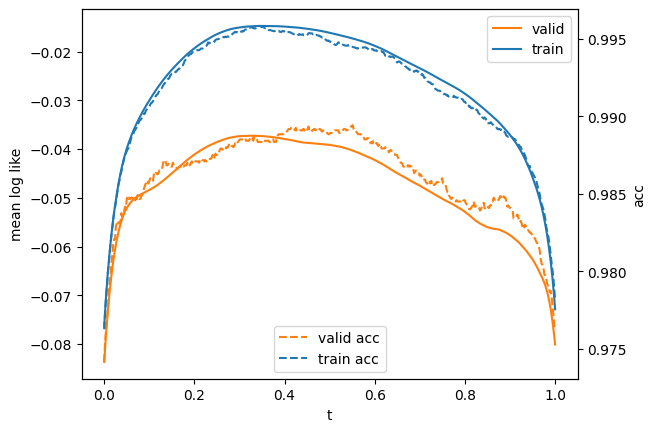

In [14]:
fig, ax = plt.subplots(1, 1)
t_space = jnp.linspace(0.0, 1.0, 500)

# valid
forward = jax.jit(lambda t: s_model.nll(
    best_params, t, x_val, y_val).mean(axis=-1))
# t_spae with shape for (sequential shape and vmapped shape)
nll = jax.lax.map(forward, t_space.reshape(-1, 20)).flatten()
acc = jax.lax.map(lambda t: acc_fn(
    best_params, t, x_val, y_val), t_space.reshape(-1, 20)).flatten()
ax.plot(t_space, -nll, label="valid", c=plt.get_cmap('tab10')(1))
ax2 = ax.twinx()
ax2.plot(t_space, acc, label="valid acc",
         c=plt.get_cmap('tab10')(1), linestyle="--")
# train
forward = jax.jit(lambda t: s_model.nll(
    best_params, t, x, y).mean(axis=-1))
nll = jax.lax.map(forward, t_space.reshape(-1, 2)).flatten()
acc = jax.lax.map(lambda t: acc_fn(
    best_params, t, x, y), t_space.reshape(-1, 2)).flatten()
ax.plot(t_space, -nll, label="train", c=plt.get_cmap('tab10')(0))
ax2.plot(t_space, acc, label="train acc",
         c=plt.get_cmap('tab10')(0), linestyle="--")

# test
forward = jax.jit(lambda t: s_model.nll(
    best_params, t, x_test, y_test).mean(axis=-1))
nll = jax.lax.map(forward, t_space.reshape(-1, 10)).flatten()
acc = jax.lax.map(lambda t: acc_fn(
    best_params, t, x_test, y_test), t_space.reshape(-1, 10)).flatten()
ax.plot(t_space, -nll, label="test", c=plt.get_cmap('tab10')(2))
ax2.plot(t_space, acc, label="test acc",
         c=plt.get_cmap('tab10')(2), linestyle="--")
print(f"best loss: {-nll.mean()}")
ax.set_xlabel("t")
ax.set_ylabel("mean log like")
ax2.set_ylabel("acc")
ax.legend()
ax2.legend(loc='lower center')

best loss: -0.0408182218670845


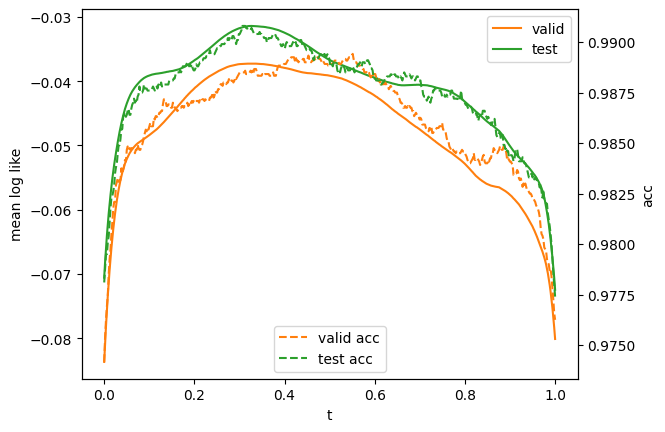

In [15]:
fig, ax = plt.subplots(1, 1)
t_space = jnp.linspace(0.0, 1.0, 500)

# valid
forward = jax.jit(lambda t: s_model.nll(
    best_params, t, x_val, y_val).mean(axis=-1))
# t_spae with shape for (sequential shape and vmapped shape)
nll = jax.lax.map(forward, t_space.reshape(-1, 20)).flatten()
acc = jax.lax.map(lambda t: acc_fn(
    best_params, t, x_val, y_val), t_space.reshape(-1, 20)).flatten()
ax.plot(t_space, -nll, label="valid", c=plt.get_cmap('tab10')(1))
ax2 = ax.twinx()
ax2.plot(t_space, acc, label="valid acc",
         c=plt.get_cmap('tab10')(1), linestyle="--")

# test
forward = jax.jit(lambda t: s_model.nll(
    best_params, t, x_test, y_test).mean(axis=-1))
nll = jax.lax.map(forward, t_space.reshape(-1, 10)).flatten()
acc = jax.lax.map(lambda t: acc_fn(
    best_params, t, x_test, y_test), t_space.reshape(-1, 10)).flatten()
ax.plot(t_space, -nll, label="test", c=plt.get_cmap('tab10')(2))
ax2.plot(t_space, acc, label="test acc",
         c=plt.get_cmap('tab10')(2), linestyle="--")
print(f"best loss: {-nll.mean()}")
ax.set_xlabel("t")
ax.set_ylabel("mean log like")
ax2.set_ylabel("acc")
ax.legend()
ax2.legend(loc='lower center')

### sampling

In [10]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(best_params['params'], k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
del cp_w
print(f"Control points in phi space: {cp_phi.shape}")

Control points in phi space: (11, 10)


In [11]:
def init_model_tube(model, params, k, t_lambda_to_phi, t_phi_to_weight, prior_correct: bool, prior_scale=0.5, d_bezier = None, log_norm_d_bezier=jnp.array(0.), dist_scale: str | float = 0.05):
    def model_tube(x, y=None, temperature=1.):
        # prior definition
        t = numpyro.sample(
            "t", dist.Uniform(-0.1, 1.1).expand((1,)).to_event(1))
        tube = numpyro.sample("tube", dist.Normal(
            0., prior_scale).expand((k-1,)).to_event(1))
        if dist_scale == 'homo':
            scale = numpyro.sample("scale", dist.LogNormal(
                0, 1.))
        else:
            scale = dist_scale

        lambda_ = jnp.concat([t, tube], axis=-1)
        space_point = t_lambda_to_phi(lambda_)

        if prior_correct:
            # jacobian = jax.jacrev(transform)(jax.lax.stop_gradient(lambda_)).squeeze()
            jacobian = jax.jacrev(t_lambda_to_phi)(lambda_)
            sign, logabsdet = jnp.linalg.slogdet(jacobian)
            numpyro.factor("logabsdet", logabsdet)
        else:
            t_det = jnp.linalg.norm(d_bezier(t), axis=-1)
            numpyro.factor("t_scale", jnp.log(t_det) - log_norm_d_bezier)

        varphi = numpyro.deterministic('varphi', space_point)
        weight_vec = t_phi_to_weight(varphi)

        def apply_model(weight_vec, x):
            weight_pytree = vec_to_pytree(weight_vec, params)
            out = model.apply({'params': weight_pytree}, x)
            return out
        logit = apply_model(weight_vec, x)
        with numpyro.plate("data", x.shape[0], dim=-1):
            with handlers.scale(scale=1/temperature):
                numpyro.sample("obs", dist.CategoricalLogits(logit), obs=y)
    return model_tube

space_at_t0 shape (10, 10)
Stores 26 orthogonal frames  
with ortho frame shape (26, 10, 10)


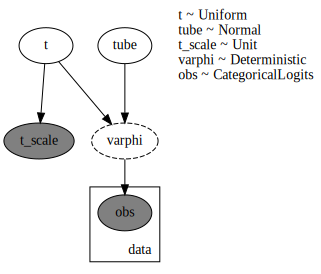

In [12]:
t_lambda_to_phi, curve, d_bezier = init_t_lambda_to_phi(cp_phi,
                                                        k,
                                                        epsilon=config['sampling']['space_config']['epsilon'],
                                                        tube_scale=config['sampling']['space_config']['tube_scale'])

tt = jnp.linspace(0., 1., 10_000)
bezier_grad = jax.vmap(d_bezier)(tt)
log_normalized_bezier_grad = jnp.log(jnp.trapezoid(
    jnp.linalg.norm(bezier_grad, axis=-1), tt))

model_tube = init_model_tube(model,
                             params['params'],
                             k,
                             t_lambda_to_phi,
                             t_phi_to_weight,
                             prior_correct=config['sampling']['space_config']['prior_correct'],
                             prior_scale=config['sampling']['space_config']['prior_scale'],
                             d_bezier=d_bezier,
                             log_norm_d_bezier=log_normalized_bezier_grad,
                             #  dist_scale=jnp.exp(best_params['dist_params']['log_scale']).item())
                             dist_scale="homo" if config['curve_params']['optimize_distparams'] else jnp.exp(best_params['dist_params']['log_scale']).item())


# Example usage:
numpyro.render_model(model_tube, model_args=(
    x[0:2], y[0:2]), render_distributions=True)

In [13]:
# print format shapes
with handlers.seed(rng_seed=0):
    traced = handlers.trace(model_tube).get_trace(x[:2], y[:2])
print(numpyro.util.format_shapes(traced))

Trace Shapes:      
 Param Sites:      
Sample Sites:      
       t dist   | 1
        value   | 1
    tube dist   | 9
        value   | 9
 t_scale dist   | 0
        value   | 0
   data plate 2 |  
     obs dist 2 |  
        value 2 |  


In [19]:
num_chains = config['sampling']['num_chains']
temperature = config['sampling']['temperature']
n_samples_nuts = 2
num_warmup = config['sampling']['num_warmup'] * n_samples_nuts//2
num_draws = config['sampling']['num_draws'] * n_samples_nuts//2
PARALLEL = "VMAP"
PARALLEL = "SEQUENTIAL"

rng_key = random.PRNGKey(1)


def warmup_fn(rng_key, initial_position, init_fn, num_warmup=num_warmup):
    # run warmup adaption
    rng_key, warmup_key = jax.random.split(rng_key)
    warmup_key = jax.random.split(warmup_key, num_chains)

    time_start = time.time()

    if PARALLEL == "PMAP":
        run = jax.pmap(init_fn, in_axes=(0, 0, None), static_broadcasted_argnums=(
            2,), devices=jax.devices('cpu'))
    elif PARALLEL == "VMAP":
        run = jax.vmap(init_fn, in_axes=(0, 0, None))
    elif PARALLEL == "SEQUENTIAL":
        def run(rng_key, initial_position, num_warmup):
            def scan_fn(carry, xs):
                rng_key, init_pos = xs
                return None, init_fn(rng_key, init_pos, num_warmup)
            carry, (last_state, parameters) = jax.lax.scan(scan_fn, None, (rng_key, initial_position))
            return last_state, parameters

    last_state, parameters = run(warmup_key, initial_position, num_warmup)
    jax.block_until_ready(last_state)
    time_ = time.time() - time_start
    return time_, rng_key, last_state, parameters


def run_inference(kernel, rng_key, last_state, parameters, num_samples=num_draws):
    rng_key, sample_key = jax.random.split(rng_key)
    sample_keys = jax.random.split(sample_key, num_chains)

    def inference_loop(rng_key, parameters, initial_state, num_samples):
        final_state, trace_state, trace_info = blackjax.util.run_inference_algorithm(
            rng_key=rng_key,
            initial_state=initial_state,
            inference_algorithm=kernel(parameters),
            num_steps=num_samples,
            # transform=transform,
            progress_bar=False,
        )
        return trace_state, trace_info

    # run inference loop
    if PARALLEL == "PMAP":
        inference_loop_multiple_chains = jax.pmap(inference_loop,
                                                  in_axes=(0, 0, 0, None),
                                                  static_broadcasted_argnums=(
                                                      3,),
                                                  devices=jax.devices('cpu'))
    elif PARALLEL == "VMAP":
        inference_loop_multiple_chains = jax.vmap(inference_loop, in_axes=(
            0, 0, 0, None))
    elif PARALLEL == "SEQUENTIAL":
        def inference_loop_multiple_chains(rng_key, parameters, initial_state, num_samples):
            def scan_fn(carry, xs):
                rng_key, parameters, initial_state = xs
                return None, inference_loop(rng_key, parameters, initial_state, num_samples)
            carry, (state, info) = jax.lax.scan(
                scan_fn, None, (rng_key, parameters, initial_state))
            return state, info


        # inference_loop_multiple_chains = lambda rng_key, parameters, initial_state, num_samples: jax.tree.map(partial(inference_loop, num_samples=num_samples), rng_key, parameters, initial_state)

    # jax.debug.print(f"params: {parameters['max_num_doublings']}")
    time_start = time.time()
    pmap_states, pmap_infos = inference_loop_multiple_chains(
        sample_keys, parameters, last_state, num_samples)
    jax.block_until_ready(pmap_states)
    time_ = time.time() - time_start
    return time_, rng_key, pmap_states, pmap_infos


# start with sampling -> generate potential_fn for blackjax
rng_key, init_key = jax.random.split(rng_key)
init_params, potential_fn, post_proc_fun, _ = initialize_model(
    init_key,
    # model_tube,
    model_tube,
    model_args=(x, y, temperature),
    # could also set to True => potential_fn_gen(**model_args) instead of potential_fn
    dynamic_args=False,
)


def logdensity_fn(params):
    return -potential_fn(params)

In [15]:
import blackjax

In [16]:
def init_fn(warmup_key, initial_position, num_warmup):
    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=warmup_key
    )

    # build the kernel
    def kernel(sqrt_diag_cov):
        return blackjax.mcmc.mclmc.build_kernel(
            logdensity_fn=logdensity_fn,
            integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
            sqrt_diag_cov=sqrt_diag_cov,
        )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_warmup,
        state=initial_state,
        rng_key=warmup_key,
        diagonal_preconditioning=False,
    )
    return blackjax_state_after_tuning, blackjax_mclmc_sampler_params


rng_key, init_key = jax.random.split(rng_key)
initial_position = {'t': jax.random.uniform(init_key, (num_chains, 1), minval=0., maxval=1.),
                    'tube': jnp.zeros((num_chains, k-1))}
wall_time, rng_key, last_state, parameters = warmup_fn(
    rng_key, initial_position, init_fn)
print("Wall time: {:.2f} s".format(wall_time))
print("MCMC parameters:", parameters)

Wall time: 230.32 s
MCMC parameters: MCLMCAdaptationState(L=Array([0.03964676, 0.04545823, 0.03484599, 0.05416858, 0.03353697,
       0.04928719, 0.04304776, 0.03903219, 0.05285496, 0.03442479],      dtype=float32), step_size=Array([0.005195  , 0.00530905, 0.00875678, 0.0091953 , 0.00349976,
       0.01381436, 0.00935775, 0.00731487, 0.00518728, 0.00352223],      dtype=float32), sqrt_diag_cov=Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32))


In [20]:
def get_kernel(parameters):
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=parameters.L,
        step_size=parameters.step_size
    )
    return sampling_alg


wall_time, rng_key, states_phi, infos_phi = run_inference(
    get_kernel, rng_key, last_state, parameters)

print("Wall time: {:.2f} s".format(wall_time))

Wall time: 739.88 s


In [40]:
selected_states = jax.tree.map(
    lambda x: x[:, ::n_samples_nuts//2], states_phi.position)
posterior = jax.lax.map(lambda x: jax.vmap(post_proc_fun)(x), selected_states)

samples = az.from_dict(posterior=posterior)
summary = az.summary(samples)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t[0],0.365,0.013,0.342,0.389,0.002,0.002,38.0,43.0,1.19
tube[0],0.005,0.013,-0.021,0.030,0.001,0.001,261.0,357.0,1.04
tube[1],-0.017,0.020,-0.056,0.019,0.001,0.001,228.0,493.0,1.05
tube[2],-0.069,0.012,-0.092,-0.046,0.001,0.000,617.0,912.0,1.01
tube[3],-0.009,0.018,-0.041,0.024,0.002,0.001,137.0,613.0,1.06
tube[4],0.027,0.014,0.001,0.053,0.001,0.000,532.0,655.0,1.01
tube[5],-0.020,0.015,-0.047,0.011,0.001,0.001,283.0,586.0,1.04
tube[6],0.052,0.017,0.022,0.083,0.001,0.001,282.0,562.0,1.04
tube[7],0.041,0.011,0.019,0.062,0.001,0.000,379.0,700.0,1.02
tube[8],0.013,0.013,-0.010,0.037,0.001,0.000,533.0,1034.0,1.01


In [45]:
def log_like_fn(x, y, posterior):
    def single_log_like_fn(sample):
        with handlers.seed(rng_seed=0):
            cml = handlers.condition(model_tube, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, y, config['sampling']['temperature'])
            site = ex_trace['obs']
            log_like = site['fn'].log_prob(
                site['value'])
            return log_like
    # return jax.vmap(jax.vmap(single_log_like_fn))(posterior)
    return jax.vmap(lambda sample: jax.lax.map(single_log_like_fn, sample))(posterior)


def prediction(key, x, posterior):
    sample_keys = jax.random.split(key, num_chains)

    def single_prediction_fn(rng_key, sample):
        rng_key, sample_key = random.split(rng_key)
        with handlers.seed(rng_seed=sample_key):
            cml = handlers.condition(model_tube, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, None, 1.)
            site = ex_trace['obs']
            return rng_key, site['fn'].sample(sample_key)
    key, preds = jax.vmap(lambda key, sample: jax.lax.scan(
        single_prediction_fn, key, sample))(sample_keys, posterior)  # vmap over chains and scan over samples
    return key[-1], preds

In [46]:
log_like = log_like_fn(x_val, y_val,
                       posterior).reshape(-1, len(y_val))
lppd = jnp.mean(jax.scipy.special.logsumexp(
    log_like, axis=0) - jnp.log(log_like.shape[0]))
del log_like
lppd

Array(-0.03861246, dtype=float32)

In [47]:
posterior['tube'].shape

(10, 1000, 9)

In [39]:
rng_key, category = prediction(rng_key, x_val, posterior)
acc = (category.mean((0, 1)).round() == y_val).mean(-1)
# rmse = jnp.sqrt(jnp.mean((preds.mean((0, 1)) - y_val) ** 2))
del category
# rmse
print(f"lppd: {lppd}, acc: {acc}")

lppd: -0.03861246258020401, acc: 0.9819166660308838
